In [4]:
import numpy as np 
import pandas as pd 
import optuna 
from catboost import CatBoostClassifier,Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score,accuracy_score, confusion_matrix, classification_report,precision_score,f1_score
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
PROJECT_ROOT = Path.cwd().parent
os.chdir(PROJECT_ROOT)

In [6]:
X = pd.read_csv("data/fe/X_train_fe.csv")
y = pd.read_csv("data/fe/y_train.csv").squeeze()

In [7]:
cat_features = [X.columns.get_loc(c) for c in ["Sex", "Embarked", "Title"]]

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
def objective(trial: optuna.Trial) ->float:
    params = {
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "random_seed": 42,
        "verbose": 0,
        #Гиперпараметры
        "iterations":trial.suggest_int("iterations", 300, 1500),
        "learning_rate":trial.suggest_float("learning_rate", 0.01, 0.2,log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 50.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0, log=True),
        #регуляризация
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.6, 1.0),
    }
    recalls = []
    for train_idx,val_idx in cv.split(X,y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
        val_pool = Pool(X_val, y_val, cat_features=cat_features)
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=val_pool, use_best_model=True, early_stopping_rounds=50)
        y_pred = (model.predict_proba(val_pool)[:, 1] >= 0.5).astype(int)
        recalls.append(recall_score(y_val, y_pred))
    return float(np.mean(recalls))    
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Best CV recall:", study.best_value)
print("Best params:", study.best_params)
    

[I 2025-12-26 01:36:11,825] A new study created in memory with name: no-name-63d876de-09e3-45ba-802e-b7c8bccf6f01
[I 2025-12-26 01:36:25,059] Trial 0 finished with value: 0.6921212121212121 and parameters: {'iterations': 1351, 'learning_rate': 0.07383432168202997, 'depth': 7, 'l2_leaf_reg': 1.414493443927875, 'random_strength': 0.024052832937066455, 'subsample': 0.829654359350077, 'colsample_bylevel': 0.8450591485739896}. Best is trial 0 with value: 0.6921212121212121.
[I 2025-12-26 01:36:32,817] Trial 1 finished with value: 0.7105050505050505 and parameters: {'iterations': 484, 'learning_rate': 0.10089101964549037, 'depth': 5, 'l2_leaf_reg': 4.557791046070796, 'random_strength': 3.7947006835412506e-05, 'subsample': 0.7969956366368582, 'colsample_bylevel': 0.8624096467852025}. Best is trial 1 with value: 0.7105050505050505.
[I 2025-12-26 01:36:41,446] Trial 2 finished with value: 0.6921885521885522 and parameters: {'iterations': 1242, 'learning_rate': 0.1099000501559372, 'depth': 5, 'l

Best CV recall: 0.7397979797979799
Best params: {'iterations': 740, 'learning_rate': 0.027058354617316642, 'depth': 10, 'l2_leaf_reg': 12.33541526352288, 'random_strength': 8.532584197818398, 'subsample': 0.8645959984155855, 'colsample_bylevel': 0.7017885490683493}


In [10]:
X_test = pd.read_csv("data/fe/X_test_fe.csv")
y_test = pd.read_csv("data/fe/y_test.csv").squeeze()


In [11]:
best_params = study.best_params
final_params = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "random_seed": 42,
    "verbose": 100,
    **best_params
}

In [12]:
train_pool = Pool(X, y, cat_features=cat_features)
test_pool  = Pool(X_test, y_test, cat_features=cat_features)

In [13]:
final_model = CatBoostClassifier(**final_params)
final_model.fit(train_pool)

0:	total: 3.87ms	remaining: 2.86s
100:	total: 1.93s	remaining: 12.2s
200:	total: 3.9s	remaining: 10.5s
300:	total: 5.9s	remaining: 8.61s
400:	total: 8.51s	remaining: 7.2s
500:	total: 11.4s	remaining: 5.45s
600:	total: 14.9s	remaining: 3.44s
700:	total: 18.2s	remaining: 1.01s
739:	total: 19.6s	remaining: 0us


In [14]:
y_pred = (final_model.predict_proba(test_pool)[:, 1] >= 0.5).astype(int)

In [15]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8212290502793296
Confusion matrix:
 [[100  10]
 [ 22  47]]
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       110
           1       0.82      0.68      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



In [16]:
accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 -accuracy
print(f'Точность R^2: {accuracy}')
print(f'Доля ошибочных классификаций: {error_rate}')

Точность R^2: 0.8212290502793296
Доля ошибочных классификаций: 0.17877094972067042


Text(50.722222222222214, 0.5, 'True Label')

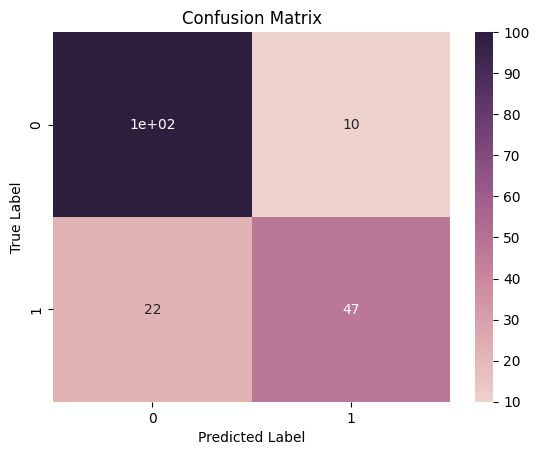

In [17]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [18]:
precision = precision_score(y_test, y_pred)
print(precision)

0.8245614035087719


In [19]:
f1 = f1_score(y_test, y_pred)
print(f1)

0.746031746031746
